In [1]:
%config Completer.use_jedi = False
import scanpy as sc
import pandas as pd
sc.set_figure_params(dpi = 120)
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

# create a color dictionary for tissues
def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
             'Eye': '#c7ea46',#"#00ff7f",
             'Fat': '#e7cb94',
             'Heart': '#ff0800',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Liver': '#000080',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Mammary':'#ce6dbd',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Prostate':'#637939',#'#a55194',#
             'Salivary_Gland':'#622a0f',
             'Skin': '#de9ed6',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Tongue':'#b5cf6b',
             'Trachea': '#969696',
             'Uterus':'#c64b8c',#'#ff0090',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict


IGHG_genes = ['IGHG1', 'IGHG2', "IGHG3", "IGHG4"]
IGHA_genes = ['IGHA1', 'IGHA2']
IGHMD_genes = ["IGHM", "IGHD"]
IGH_genes = ['IGHM', 'IGHD', "IGHE"] + IGHA_genes + IGHG_genes

In [2]:
cell_label = 'cell_ontology_class'
# cannot currently read this object because it kills my kernel
adata = sc.read_h5ad('../data/h5ads/TSP1_TSP15_scvi_donor-method_normalized-log1p-scaled_annotated.h5ad', backed='r+')

adata = adata[adata.obs.cell_ontology_class.str.contains('b cell|plasma cell')]

adata = adata.to_memory()


adata = adata[~adata.obs.cell_ontology_class.str.contains('club')]
adata = adata[~adata.obs.cell_ontology_class.str.contains('doublet')]


In [3]:
print(adata.obs.cell_ontology_class.value_counts())

b cell                   19884
memory b cell            15749
plasma cell              11593
naive b cell              6818
b cell, cd19-positive        1
Name: cell_ontology_class, dtype: int64


In [4]:
kmeans = True

if kmeans:
    adata = adata[:,adata.var.index.isin(IGH_genes)]

In [5]:
def _pp(adata, log, normalize, remove_dissociation):
    if normalize:
        sc.pp.normalize_total(adata)
    if log:
        sc.pp.log1p(adata, chunk_size=50000)
        adata.raw = adata 

    if remove_dissociation:
    #mouse2human = pd.read_csv('../metadata/mouse2human.csv')
        dissociation_genes = pd.read_csv('../metadata/Mouse2Human_dissociation_genes.csv')
        adata.var['not_dissociation_gene'] = ~adata.var.index.isin(dissociation_genes['Human gene name'])
        adata = adata[:, adata.var.not_dissociation_gene == True]
    return adata

In [6]:
adata = _pp(adata, True, True, False)

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
sc.pp.scale(adata)

In [8]:


sc.tl.score_genes(adata
                  , gene_list=IGHG_genes, 
                  score_name='IgG_Score')
sc.tl.score_genes(adata, gene_list=IGHA_genes, 
                  
                  score_name='IgA_Score')
sc.tl.score_genes(adata, gene_list=IGHMD_genes, 
                 
                  score_name='IgMD_Score')



In [9]:
sc.pp.pca(adata)

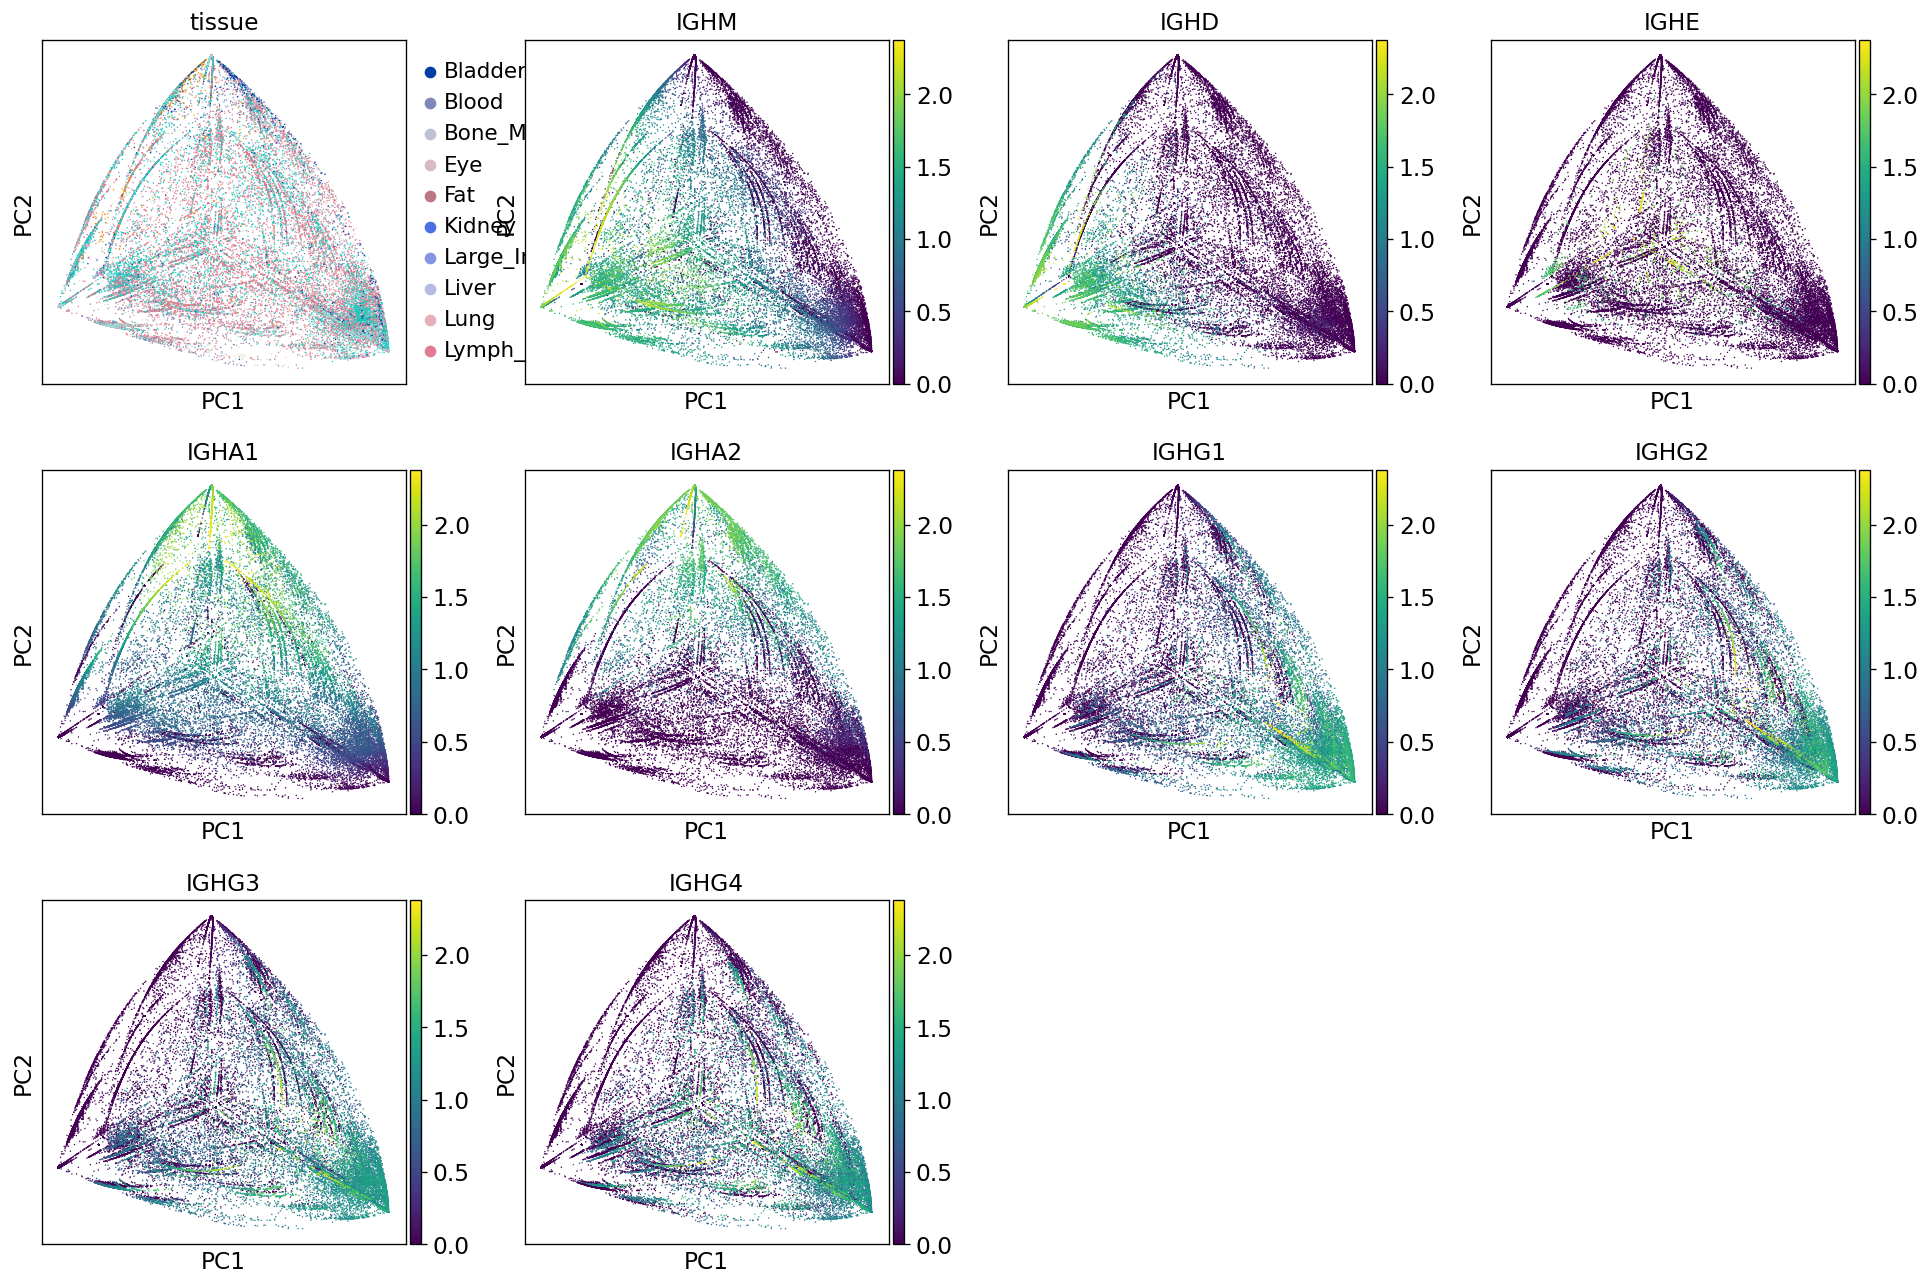

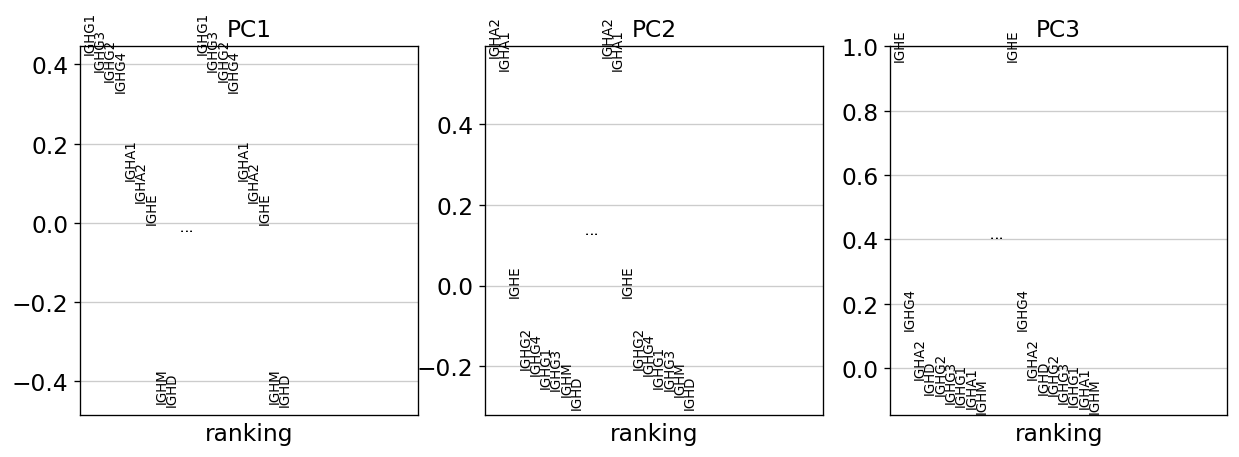

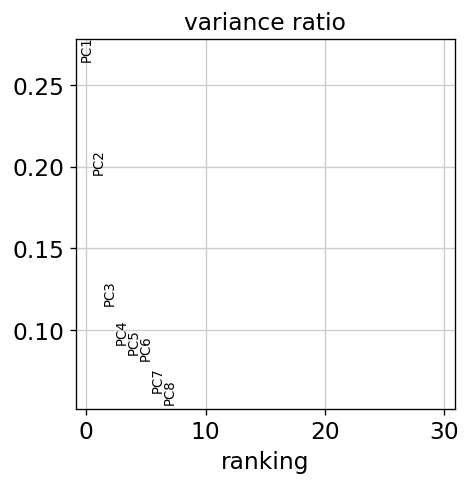

In [10]:
sc.pl.pca_overview(adata, color = ['tissue'] + IGH_genes, projection = '2d', size = 3)

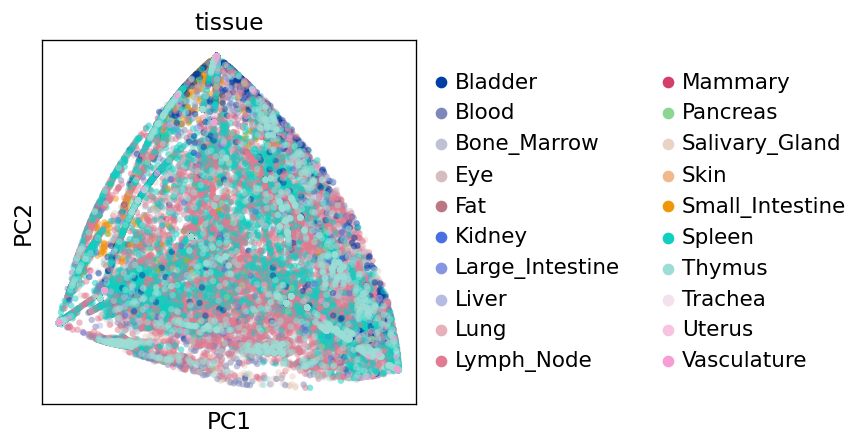

In [29]:
sc.pl.pca(adata, color = ['tissue'], projection = '2d', add_outline=False, size=60, alpha = 0.5)

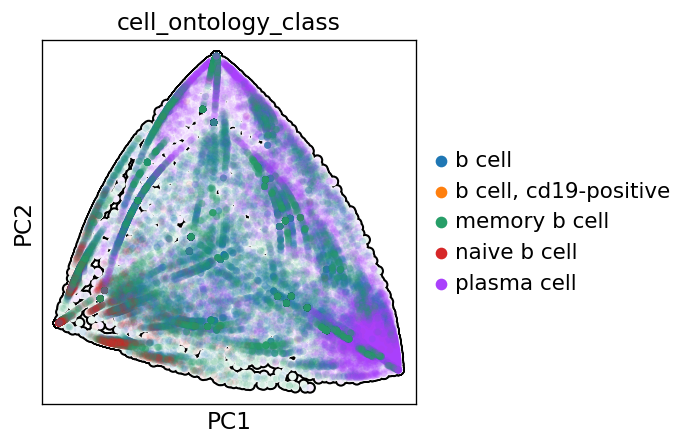

In [32]:
sc.pl.pca(adata, color = ['cell_ontology_class'], projection = '2d', add_outline=True, size = 70, alpha = 0.1)

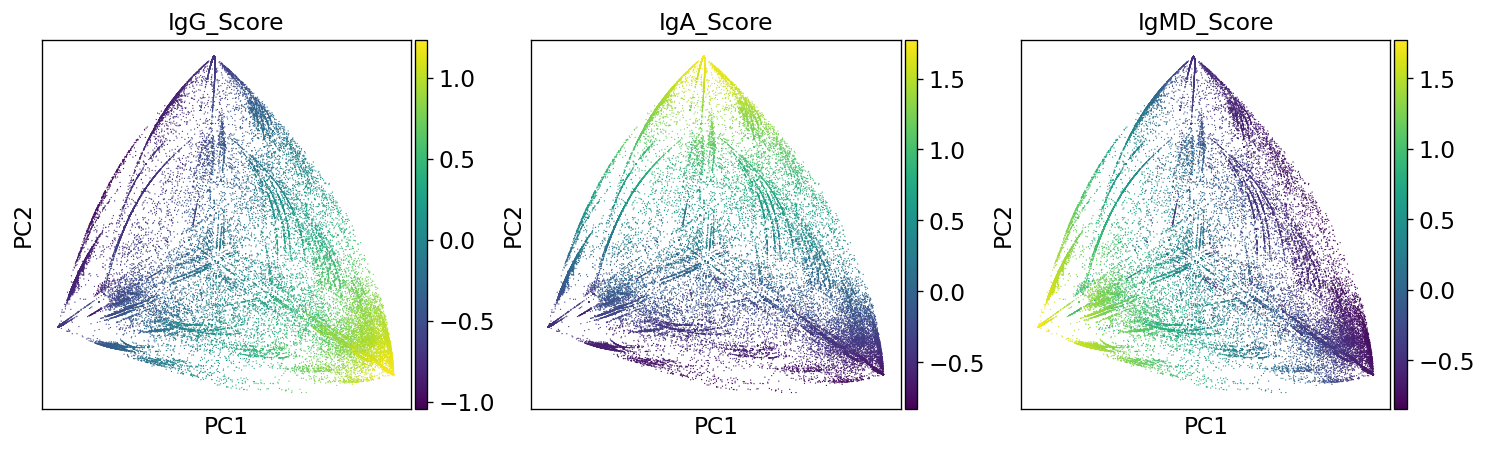

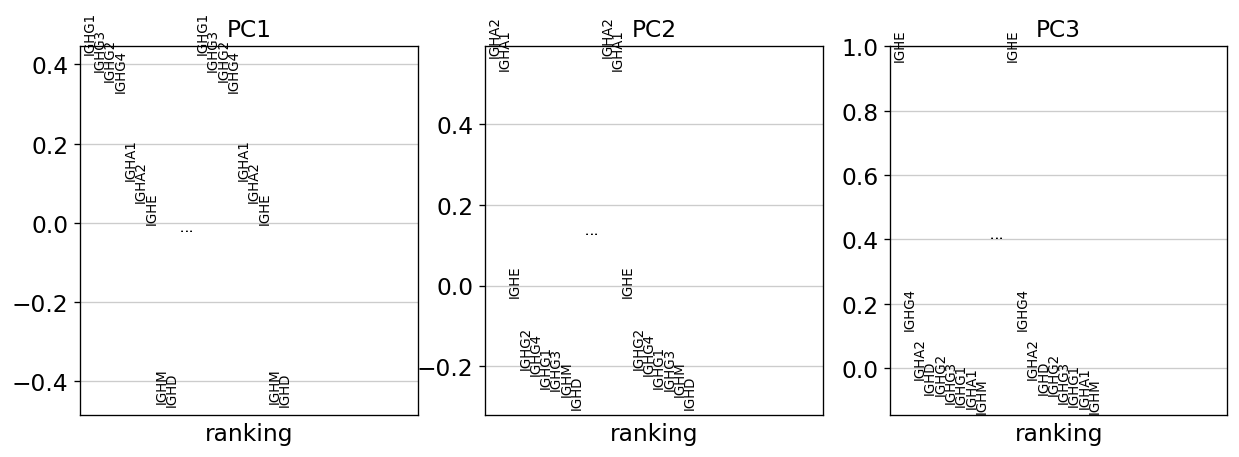

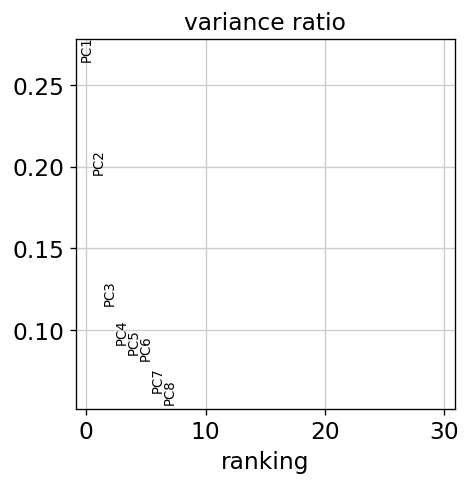

In [25]:
sc.pl.pca_overview(adata,color = ['IgG_Score', 'IgA_Score', 'IgMD_Score'], use_raw = True)

In [14]:
plotdf = sc.get.obs_df(
                adata,
                keys=['IGHD', 'IGHG1', "IGHG2", 'IGHG4', 'IGHG3', 'IGHA1', "IGHA2", "IGHM", 'IGHE', 'tissue', 
                      'IgG_Score', 'IgA_Score', 'IgMD_Score', 'cell_ontology_class'])

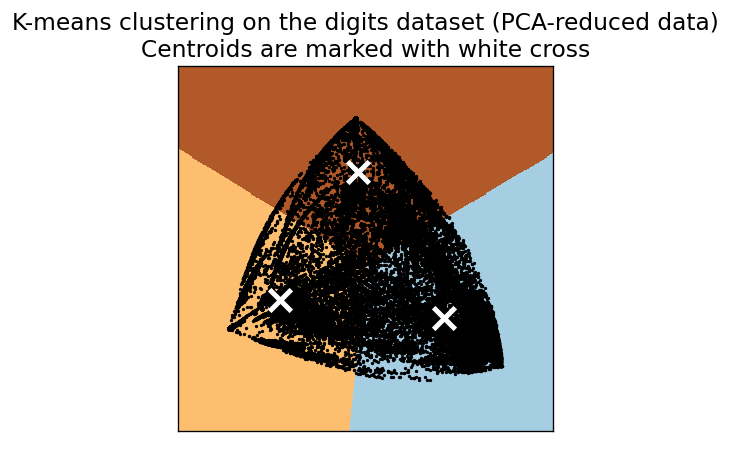

In [15]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA

data = plotdf[IGH_genes]

#data = np.log10(data + 1)

#data = preprocessing.normalize(data)


#pca = PCA(n_components=5).fit(data)

#scaler = preprocessing.StandardScaler().fit(data)

data_scaled = np.double(data)

import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data_scaled)
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=6)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

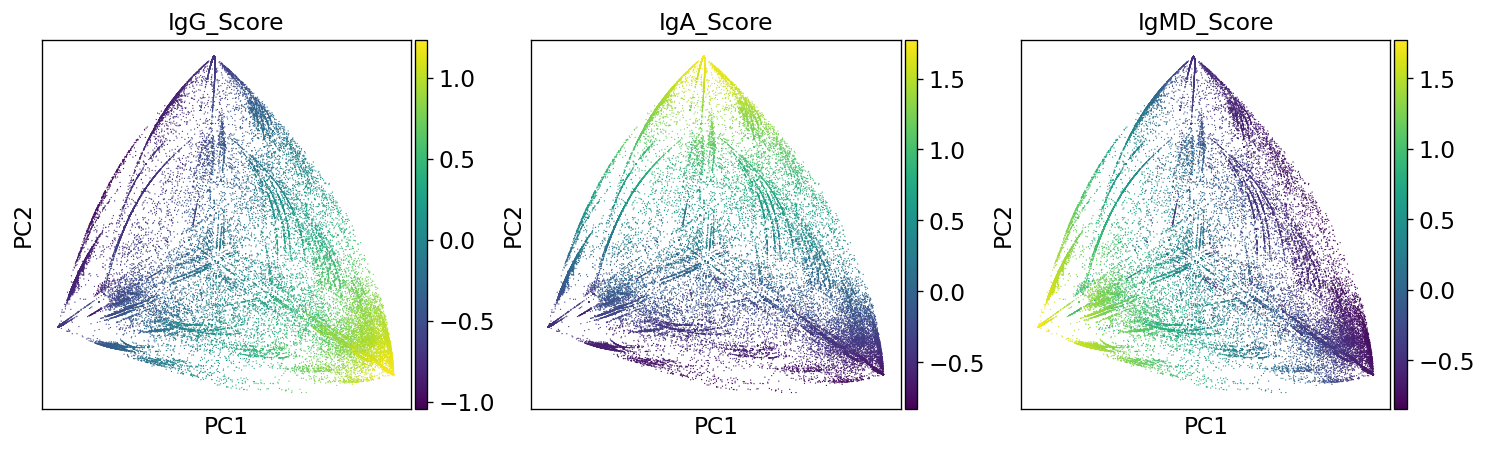

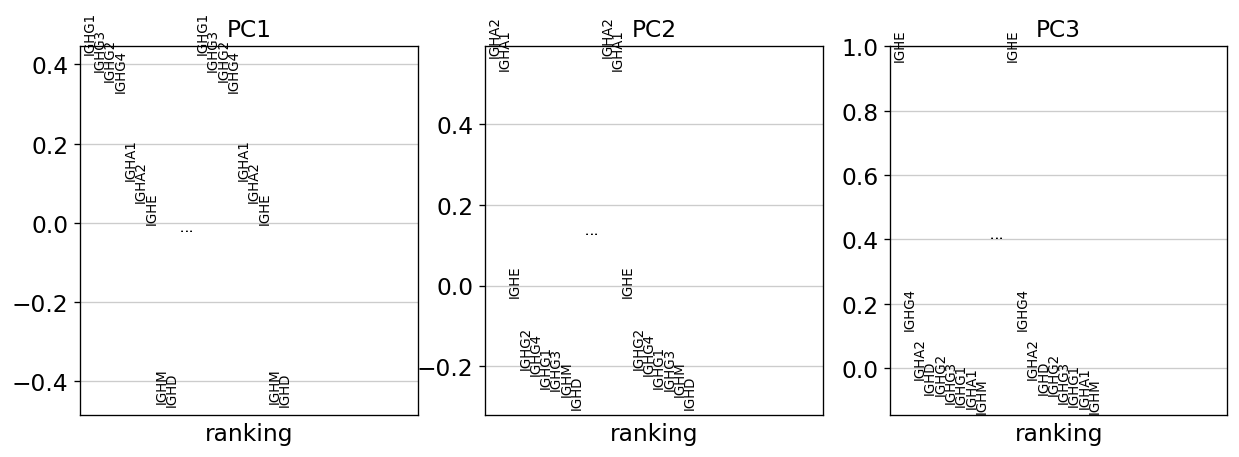

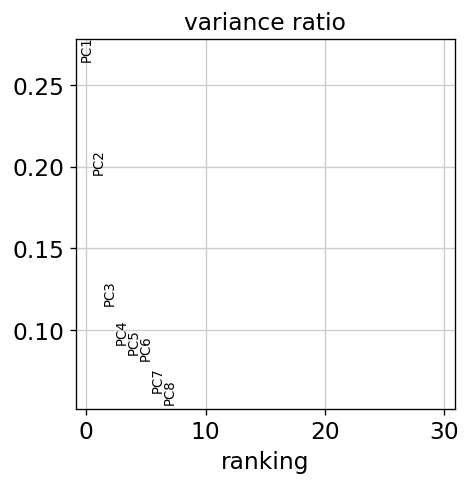

In [16]:
sc.pl.pca_overview(adata,color = ['IgG_Score', 'IgA_Score', 'IgMD_Score'], use_raw = False)

In [27]:
# well that's one way of doing it

In [29]:
scores

IgG_Score  IgA_Score  \
cell_id                                                                    
AACAAGATCACGAGGA_TSP6_Liver_NA_10X_1_1               0.000000   0.000000   
ACTCCCAGTCGGTAAG_TSP6_Liver_NA_10X_1_1               0.345518  -0.197439   
CACTAAGGTTCCTAGA_TSP6_Liver_NA_10X_1_1              -0.812310   1.454390   
CATCGGGAGCGAGAAA_TSP6_Liver_NA_10X_1_1               0.100348  -0.388867   
CATGCCTAGCAAACAT_TSP6_Liver_NA_10X_1_1              -0.680450  -0.486036   
...                                                       ...        ...   
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immu...   0.115576   0.209078   
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immu...  -0.770992   1.927480   
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immu...  -0.479579  -0.342556   
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immu...  -0.886503   0.814020   
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immu...   1.529292  -0.873881   

                                                    IgMD_Score  
cell_id                                                         
AACAAGATCACGAGGA_TSP6_Liver_NA_10X_1_1                0.000000  
ACTCCCAGTCGGTAAG_TSP6_Liver_NA_10X_1_1               -0.197439  
CACTAAGGTTCCTAGA_TSP6_Liver_NA_10X_1_1               -0.003838  
CATCGGGAGCGAGAAA_TSP6_Liver_NA_10X_1_1               -0.863995  
CATGCCTAGCAAACAT_TSP6_Liver_NA_10X_1_1                1.701126  
...                                                        ...  
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immu...   -0.249458  
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immu...   -0.550709  
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immu...    1.198948  
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immu...    0.769021  
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immu...   -0.873881  

[54045 rows x 3 columns]